In [197]:
import time

start_time = time.time()

number_image = 4

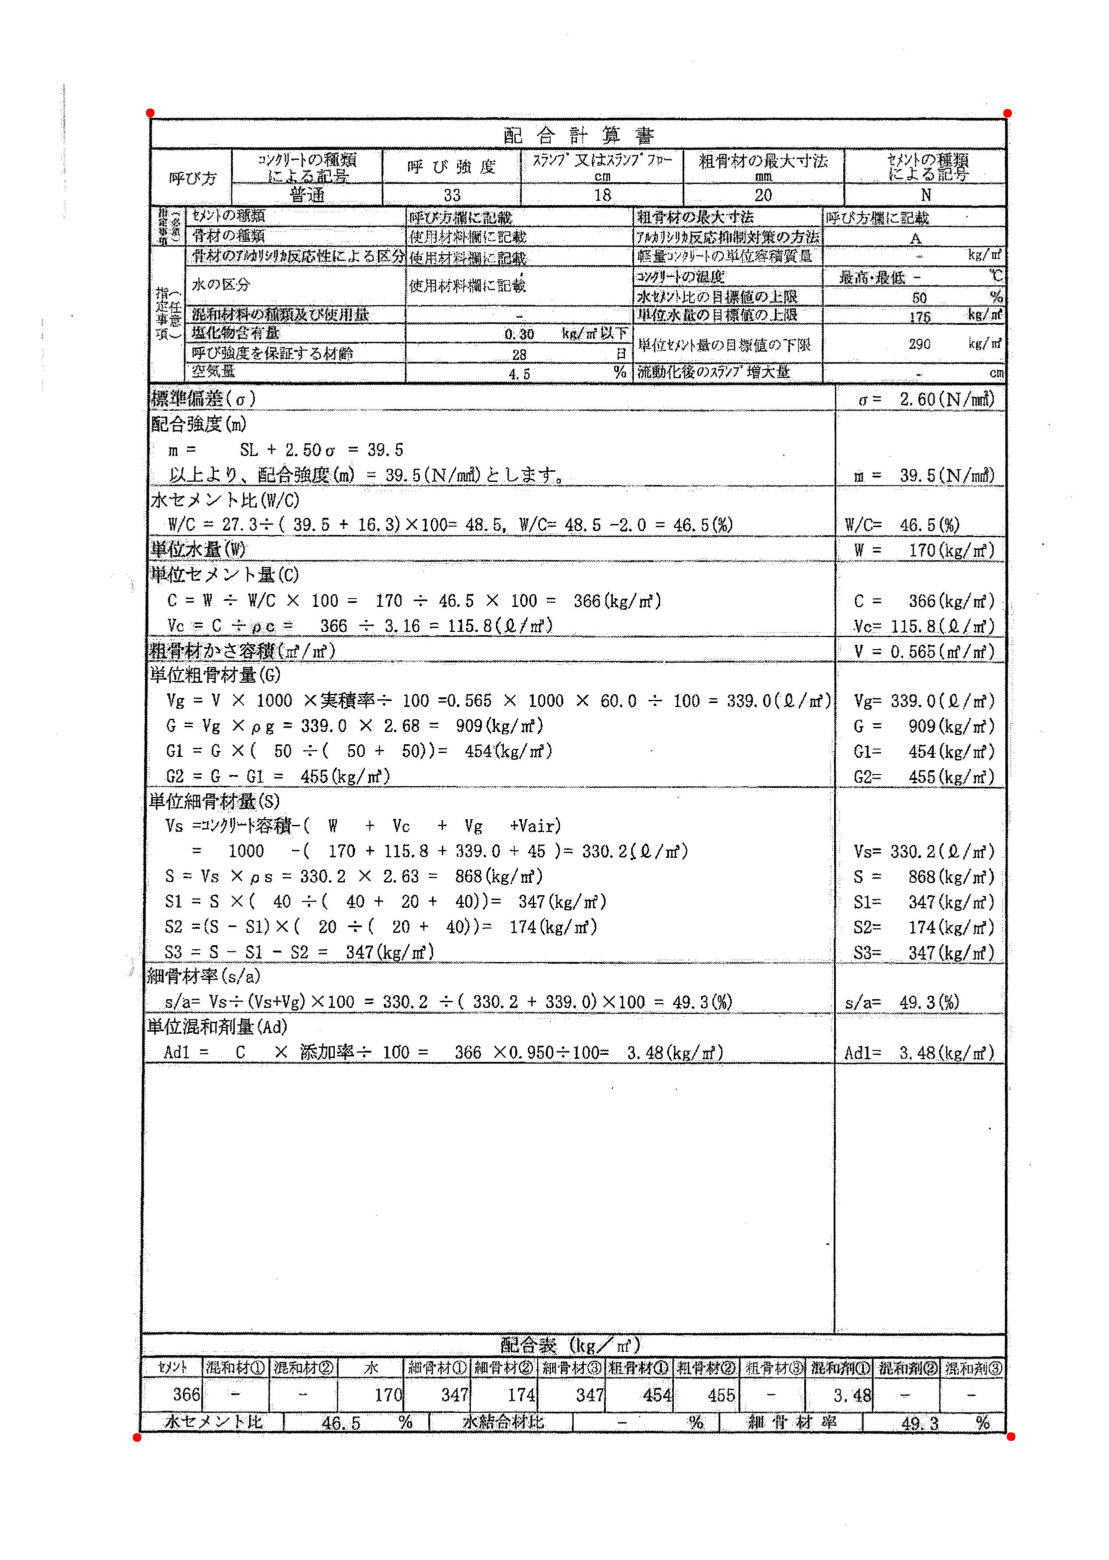

In [198]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đọc ảnh đầu vào
image_path = 'image_input/image_table_' + str(number_image) + '.jpg'
image = cv2.imread(image_path)

# Làm sắc nét ảnh bằng bộ lọc Gaussian
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
sharpened = cv2.filter2D(image, -1, kernel)

# Chuyển đổi ảnh sang xám
gray = cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY)

# Sử dụng Canny để phát hiện cạnh
edges = cv2.Canny(gray, 50, 150)

# Áp dụng phép giãn và phép đóng để lấp đầy các khoảng trống
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=2)
closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)

# Tìm đường bao ngoài cùng
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Vẽ đường bao lên ảnh gốc
output_image = image.copy()
if contours:
    # Tìm contour lớn nhất, tức là khung bao ngoài cùng
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Xấp xỉ contour thành một đa giác
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    # Lấy 4 điểm góc của contour
    if len(approx) == 4:
        corner_points = approx.reshape(4, 2)
    else:
        rect = cv2.minAreaRect(largest_contour)
        corner_points = cv2.boxPoints(rect)
        corner_points = np.int0(corner_points)
    
    # Vẽ 4 điểm góc lên ảnh
    for point in corner_points:
        cv2.circle(output_image, tuple(point), 10, (0, 0, 255), -1)

# Hiển thị ảnh kết quả
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Preprocessing ##

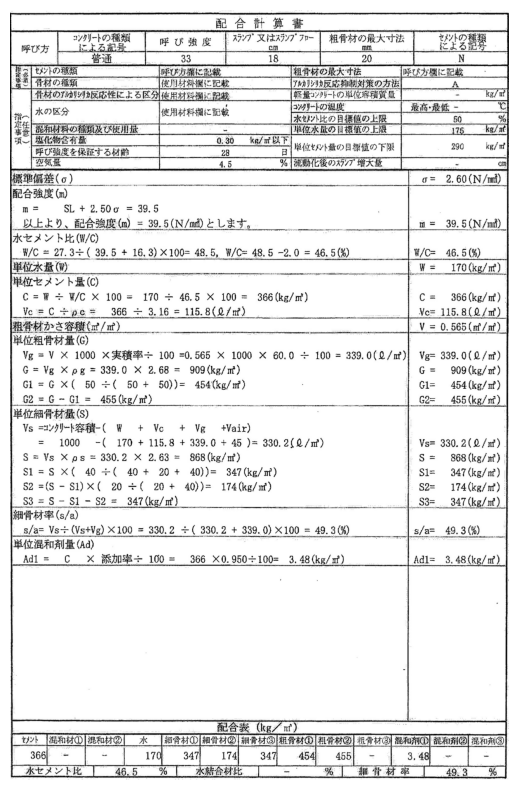

In [199]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đọc ảnh đầu vào
image_path = 'image_input/image_table_' + str(number_image) + '.jpg'
image = cv2.imread(image_path)

# Làm sắc nét ảnh bằng bộ lọc
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
sharpened = cv2.filter2D(image, -1, kernel)

# Chuyển đổi ảnh sang xám
gray = cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY)

# Sử dụng Canny để phát hiện cạnh
edges = cv2.Canny(gray, 50, 150)

# Áp dụng phép giãn và phép đóng để lấp đầy các khoảng trống
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=2)
closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)

# Tìm đường bao ngoài cùng
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # Tìm contour lớn nhất
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Xấp xỉ contour thành một đa giác
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    # Lấy 4 điểm góc của contour, nếu không đủ 4 điểm thì dùng bounding box
    if len(approx) == 4:
        corner_points = approx.reshape(4, 2)
    else:
        rect = cv2.minAreaRect(largest_contour)
        corner_points = cv2.boxPoints(rect)
        corner_points = np.int0(corner_points)
    
    # Sắp xếp các điểm theo thứ tự (top-left, top-right, bottom-right, bottom-left)
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    box = order_points(corner_points)

    # Tính kích thước của bounding box
    width = int(np.linalg.norm(box[1] - box[0]))
    height = int(np.linalg.norm(box[2] - box[1]))

    # Tạo ma trận biến đổi phối cảnh
    dst_pts = np.array([
        [0, 0],
        [width-1, 0],
        [width-1, height-1],
        [0, height-1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(box, dst_pts)

    # Áp dụng phép biến đổi phối cảnh để lấy hình ảnh mới chứa contour
    warped = cv2.warpPerspective(image, M, (width, height))

    # Hiển thị ảnh mới chứa contour
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


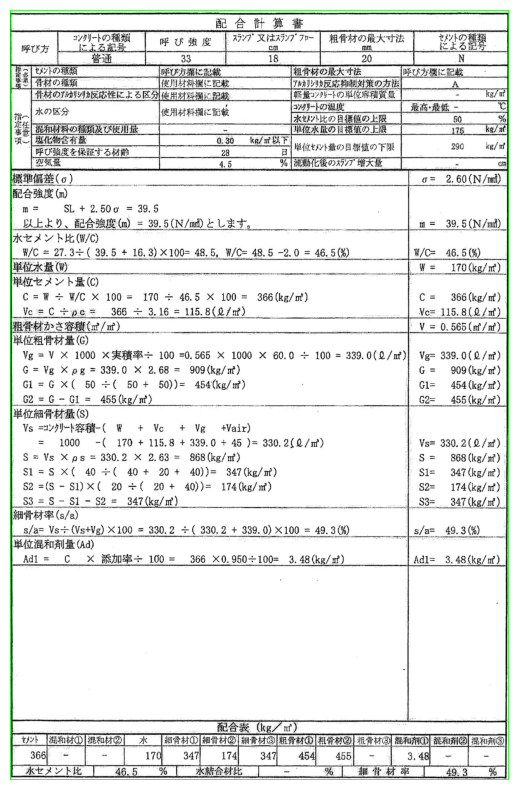

In [200]:
# Chuyển đổi các điểm trong dst_pts sang tuple của số nguyên
dst_pts_int = [tuple(map(int, pt)) for pt in dst_pts]

# Vẽ các đường thẳng nối các điểm trong dst_pts_int
cv2.line(warped, dst_pts_int[0], dst_pts_int[1], (0, 255, 0), 4)
cv2.line(warped, dst_pts_int[1], dst_pts_int[2], (0, 255, 0), 4)
cv2.line(warped, dst_pts_int[2], dst_pts_int[3], (0, 255, 0), 4)
cv2.line(warped, dst_pts_int[3], dst_pts_int[0], (0, 255, 0), 4)

# Hiển thị ảnh mới chứa contour với các đường thẳng bao quanh
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## Lấy các khung bố cục ##

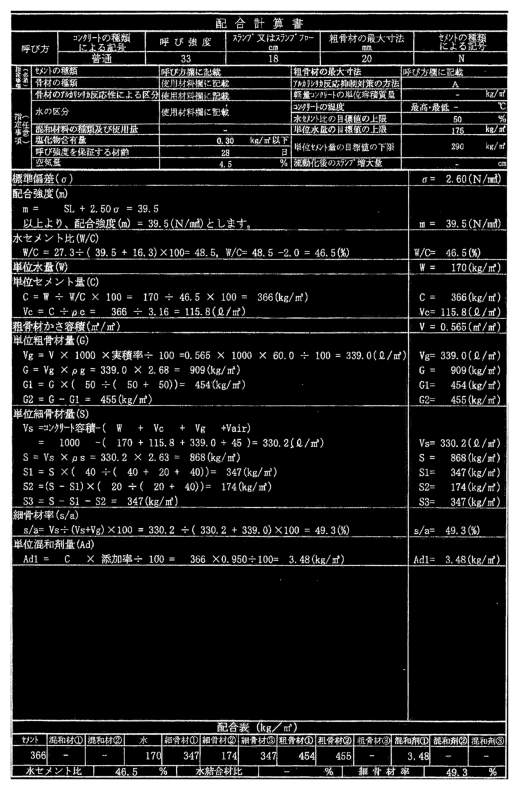

In [201]:
image_new = warped.copy()

# Chuyển ảnh sang xám
image_process = cv2.cvtColor(image_new, cv2.COLOR_BGR2GRAY)

# Thresholding
_, image_process = cv2.threshold(image_process, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Inverting
image_process = cv2.bitwise_not(image_process)

plt.figure(figsize=(10, 10))
plt.imshow(image_process, cmap='gray')
plt.axis('off')
plt.show()

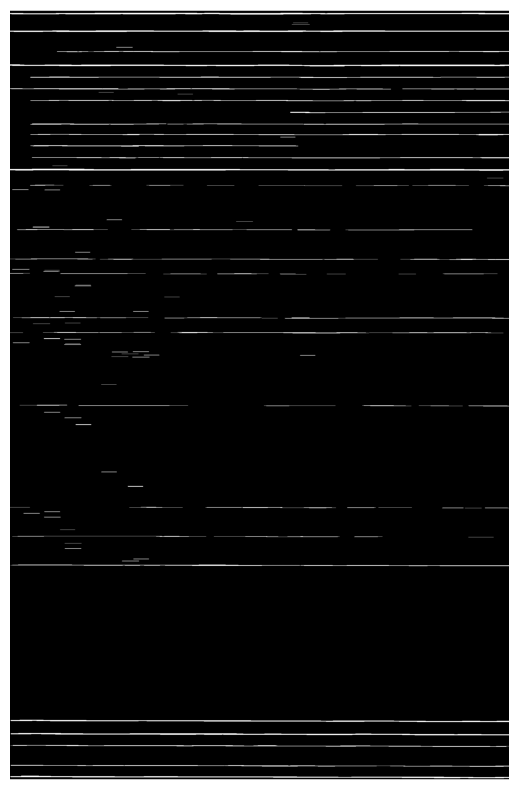

In [202]:
hor = np.array([[1,1,1,1,1,1]])
vertical_lines_eroded_image = cv2.erode(image_process, hor, iterations=6)
vertical_lines_eroded_image = cv2.dilate(vertical_lines_eroded_image, hor, iterations=10)

rows, cols = vertical_lines_eroded_image.shape

translation_matrix = np.float32([[1, 0, 8], [0, 1, 0]])

# Dịch ảnh sang phải
shifted_image = cv2.warpAffine(vertical_lines_eroded_image, translation_matrix, (cols, rows))

# Kết hợp ảnh gốc và ảnh đã dịch
vertical_lines_eroded_image = cv2.bitwise_or(vertical_lines_eroded_image, shifted_image)

plt.figure(figsize=(10, 10))
plt.imshow(vertical_lines_eroded_image, cmap='gray')
plt.axis('off')
plt.show()

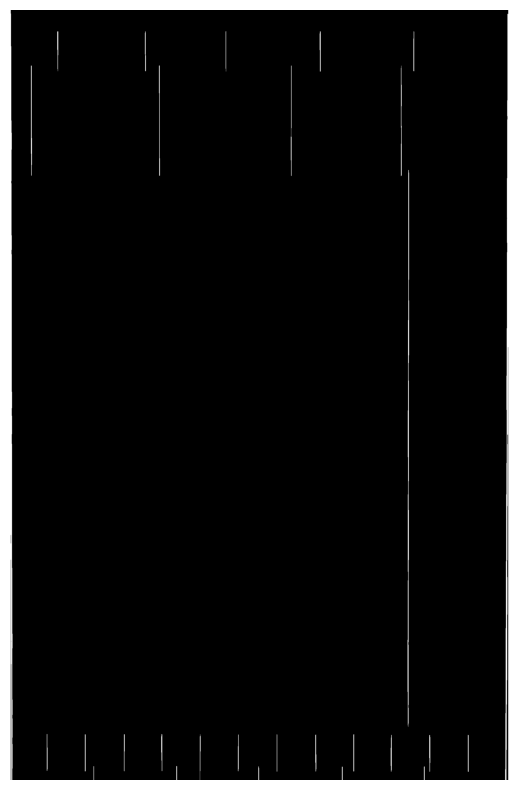

In [203]:
ver = np.array([[1],
            [1],
            [1],
            [1],
            [1],
            [1]])
horizontal_lines_eroded_image = cv2.erode(image_process, ver, iterations=8)
horizontal_lines_eroded_image = cv2.dilate(horizontal_lines_eroded_image, ver, iterations=10)

rows, cols = horizontal_lines_eroded_image.shape

translation_matrix = np.float32([[1, 0, 0], [0, 1, 6]])

# Dịch ảnh sang phải
shifted_image = cv2.warpAffine(horizontal_lines_eroded_image, translation_matrix, (cols, rows))

# Kết hợp ảnh gốc và ảnh đã dịch
horizontal_lines_eroded_image = cv2.bitwise_or(horizontal_lines_eroded_image, shifted_image)

plt.figure(figsize=(10, 10))
plt.imshow(horizontal_lines_eroded_image, cmap='gray')
plt.axis('off')
plt.show()

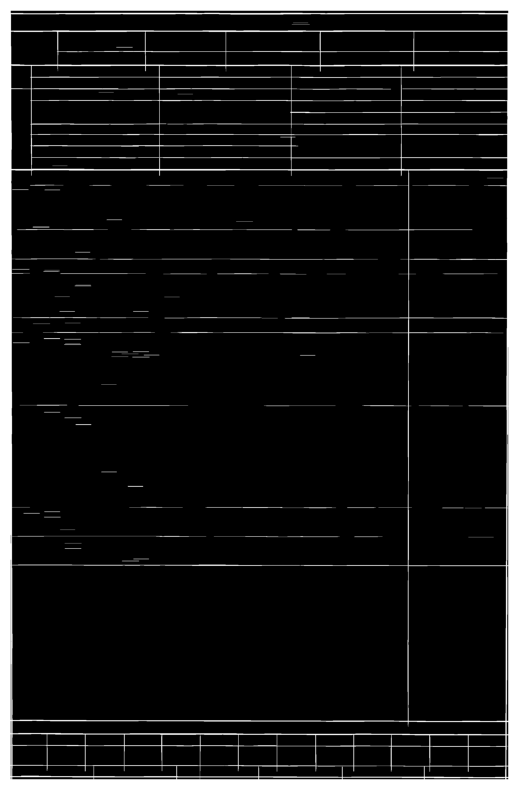

In [204]:
combined_image = cv2.add(vertical_lines_eroded_image, horizontal_lines_eroded_image)
plt.figure(figsize=(10, 10))
plt.imshow(combined_image, cmap='gray')
plt.axis('off')
plt.show()

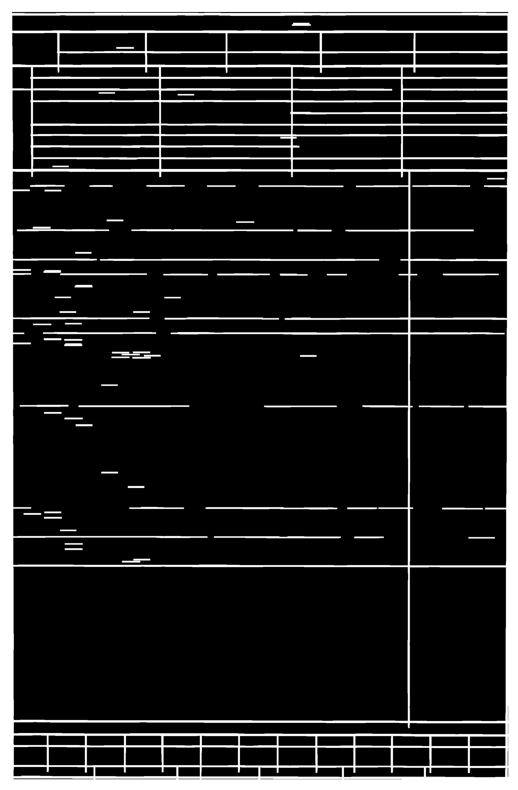

In [205]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
combined_image_dilated = cv2.dilate(combined_image, kernel, iterations=5)
plt.figure(figsize=(10, 10))
plt.imshow(combined_image_dilated, cmap='gray')
plt.axis('off')
plt.show()

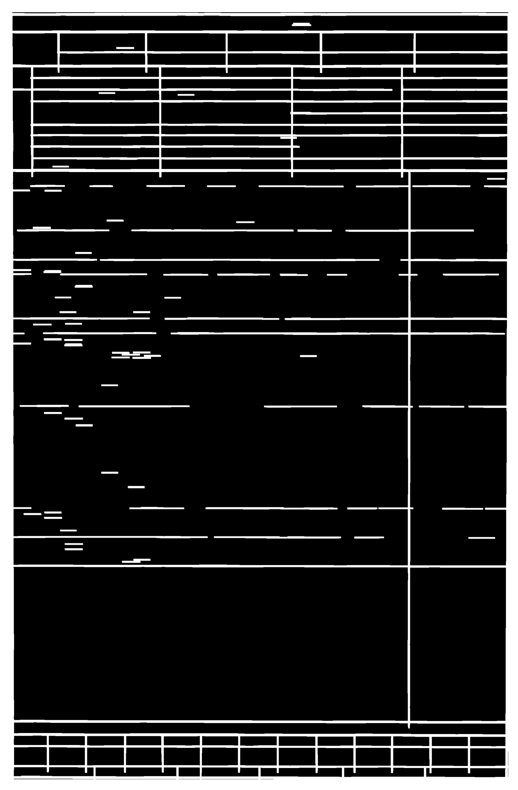

In [206]:
# Tạo ma trận dịch ảnh sang phải 5px và xuống dưới 5px
rows, cols = combined_image_dilated.shape
translation_matrix = np.float32([[1, 0, 1], [0, 1, 1]])

# Dịch ảnh sang phải
shifted_image = cv2.warpAffine(combined_image_dilated, translation_matrix, (cols, rows))

# Kết hợp ảnh gốc và ảnh đã dịch
extended_image = cv2.bitwise_or(combined_image_dilated, shifted_image)

# Hiển thị ảnh kết quả
plt.figure(figsize=(10, 10))
plt.imshow(extended_image, cmap='gray')
plt.axis('off')
plt.show()

In [207]:
combined_image_dilated = extended_image.copy()

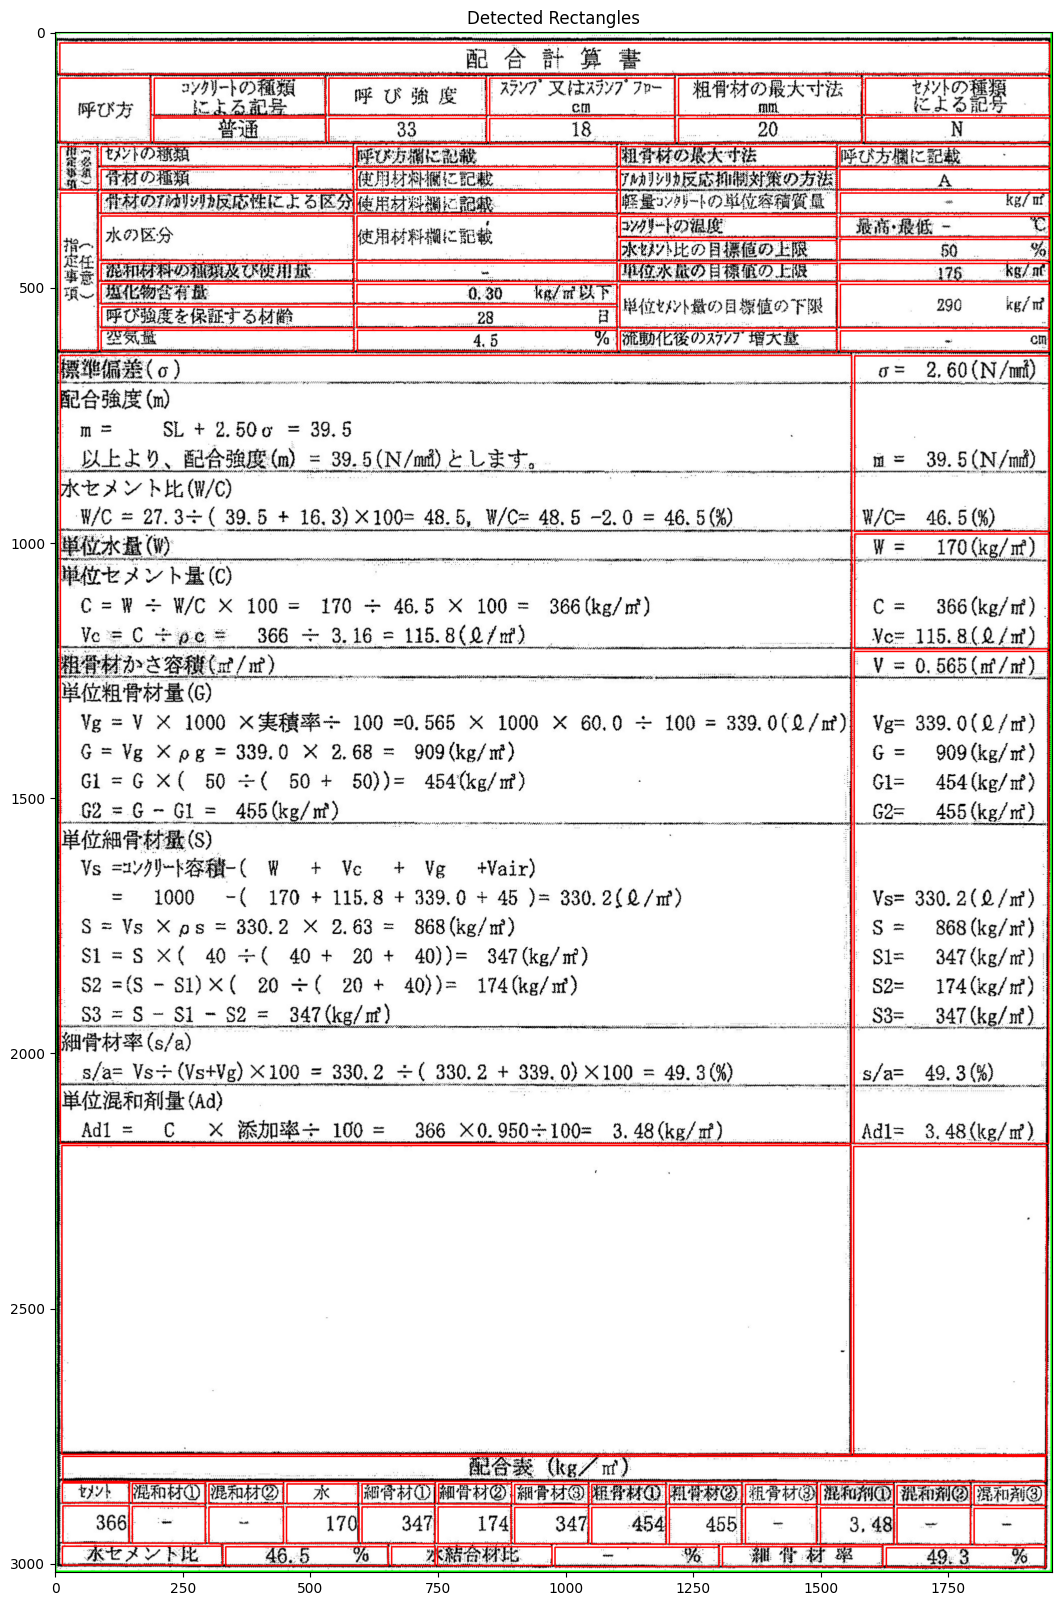

Detected Rectangles:
Rectangle 1: x=10, y=633, width=1550, height=1544
Rectangle 2: x=13, y=2181, width=1546, height=605
Rectangle 3: x=1565, y=1213, width=381, height=964
Rectangle 4: x=1564, y=2183, width=378, height=604
Rectangle 5: x=1566, y=634, width=381, height=344
Rectangle 6: x=9, y=21, width=1939, height=61
Rectangle 7: x=15, y=2790, width=1925, height=49
Rectangle 8: x=1566, y=983, width=380, height=225
Rectangle 9: x=591, y=360, width=510, height=87
Rectangle 10: x=90, y=360, width=495, height=87
Rectangle 11: x=1107, y=269, width=424, height=87
Rectangle 12: x=1106, y=494, width=426, height=85
Rectangle 13: x=1538, y=494, width=409, height=85
Rectangle 14: x=851, y=90, width=363, height=73
Rectangle 15: x=1221, y=90, width=360, height=73
Rectangle 16: x=1587, y=90, width=361, height=72
Rectangle 17: x=194, y=90, width=335, height=74
Rectangle 18: x=10, y=315, width=74, height=309
Rectangle 19: x=536, y=90, width=309, height=73
Rectangle 20: x=9, y=90, width=178, height=126

In [208]:
# Tìm contours trong ảnh nhị phân
contours, _ = cv2.findContours(combined_image_dilated, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

line_image = warped.copy()
# Lặp qua từng contour để vẽ và trích xuất hình chữ nhật
rectangles = []
count = 0
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Lọc các hình chữ nhật có diện tích và tỷ lệ phù hợp
    area = cv2.contourArea(contour)
    if area > 1000 and w > 10 and h > 10 and h < line_image.shape[0]:
        count += 1
        rectangles.append((x, y, w, h))
        cv2.rectangle(line_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Vẽ bounding box màu đỏ

rectangles_sorted = sorted(rectangles, key=lambda rect: rect[2] * rect[3], reverse=True)

# Hiển thị ảnh với các bounding box đã vẽ
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
# plt.axis('off')
plt.title('Detected Rectangles')
plt.show()

# In ra các hình chữ nhật trích xuất được
print("Detected Rectangles:")
for i, (x, y, w, h) in enumerate(rectangles_sorted, 1):
    print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")

Selected Rectangles:
Rectangle 1: x=1587, y=90, width=361, height=72
Rectangle 2: x=1221, y=90, width=360, height=73
Rectangle 3: x=851, y=90, width=363, height=73
Rectangle 4: x=536, y=90, width=309, height=73
Rectangle 5: x=194, y=90, width=335, height=74
Percent Rectangles:
No group of rectangles found that meets the criteria.
No rectangle found that meets the criteria.
Second data area: x_min_2=0, y_min_2=0, x_max_2=0, y_max_2=0


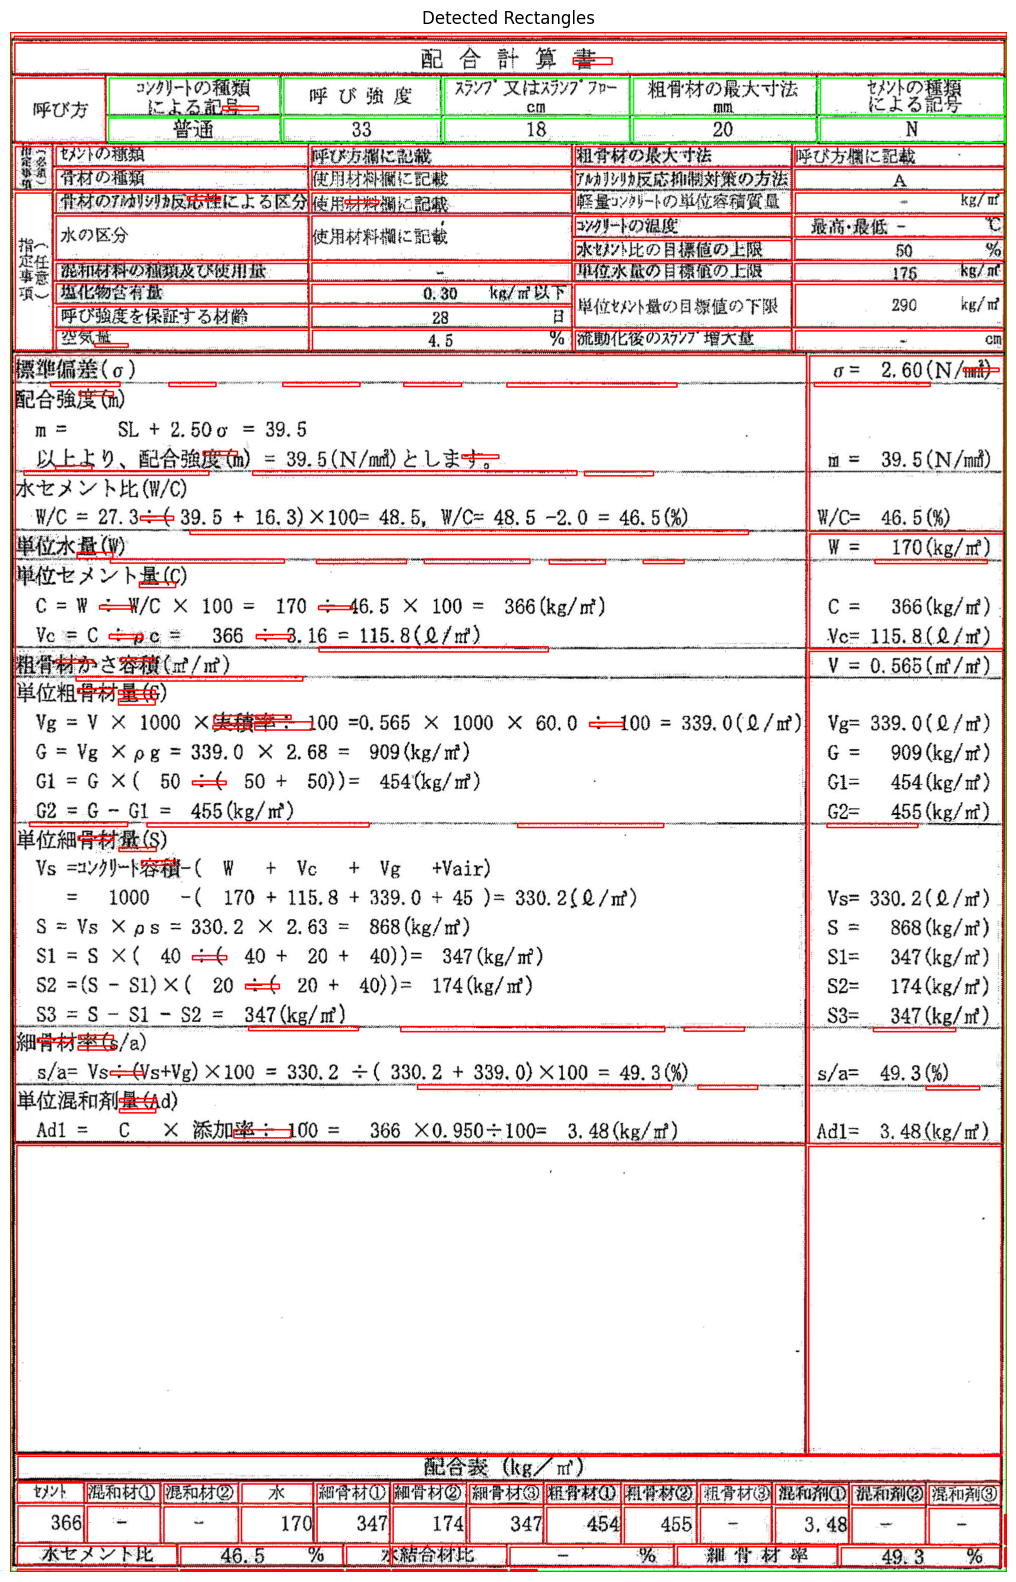

True

In [209]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Giả sử 'combined_image_dilated' là ảnh nhị phân chứa các đường ngang và dọc

# Tìm contours trong ảnh nhị phân
contours, _ = cv2.findContours(combined_image_dilated, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

line_image = warped.copy()
# Lặp qua từng contour để vẽ và trích xuất hình chữ nhật
rectangles = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Lọc các hình chữ nhật có diện tích và tỷ lệ phù hợp
    rectangles.append((x, y, w, h))
    cv2.rectangle(line_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Vẽ bounding box màu đỏ

# Sắp xếp các hình chữ nhật theo tọa độ y
rectangles_sorted = sorted(rectangles, key=lambda rect: rect[1])

# Tìm nhóm hình chữ nhật đứng cạnh nhau
def find_adjacent_rectangles(rectangles, max_y_diff=20, max_height_diff=15, min_width_ratio=0.7):
    groups = []
    groups_percent = []

    for i in range(len(rectangles)):
        group = [rectangles[i]]
        for j in range(len(rectangles)):
            if j != i:
                y_diff = abs(rectangles[j][1] - rectangles[i][1])
                height_diff = abs(rectangles[j][3] - rectangles[i][3])
                if y_diff < max_y_diff and height_diff < max_height_diff:
                    group.append(rectangles[j])
        if len(group) >= 5 and len(group) <= 6:
            groups.append(group)
        if len(group) == 6:
            groups_percent.append(group)
    return groups, groups_percent

adjacent_groups, groups_percent = find_adjacent_rectangles(rectangles_sorted)

# Tìm nhóm có tổng chiều dài chiếm phần lớn chiều dài hình ảnh
image_height, image_width = combined_image_dilated.shape
selected_groups = []
percent_group = []

for group in adjacent_groups:
    total_width = sum([w for (x, y, w, h) in group])
    if total_width > image_width * 0.8:
        selected_group = group
        selected_groups.append(selected_group)

for group in groups_percent:
    total_width = sum([w for (x, y, w, h) in group])
    if total_width > image_width * 0.9:
        percent_group = group

# Hiển thị ảnh với nhóm bounding box đã chọn
if selected_groups:
    for selected_group in selected_groups:
        for (x, y, w, h) in selected_group:
            cv2.rectangle(line_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Vẽ bounding box màu xanh lá

if percent_group:
    for (x, y, w, h) in percent_group:
        cv2.rectangle(line_image, (x, y), (x + w, y + h), (255, 0, 0), 4)  # Vẽ bounding box màu xanh duowng

# In ra các hình chữ nhật trích xuất được
print("Selected Rectangles:")
if selected_groups:
    for i, (x, y, w, h) in enumerate(selected_groups[0], 1):
        print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")
else:
    print("No group of rectangles found that meets the criteria.")

# In ra các nhóm 6 hình chữ nhật chứa dữ liệu phần trăm
print("Percent Rectangles:")
# In ra tọa độ x(max) và y(max) của percent_group
x_max_2 = 0
y_max_2 = 0
if percent_group:
    x_max_2 = max(rect[0] + rect[2] for rect in percent_group)
    y_max_2 = max(rect[1] + rect[3] for rect in percent_group)
    
    print("Percent Rectangles:")
    for i, (x, y, w, h) in enumerate(percent_group, 1):
        print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")
    
    print(f"x(max) = {x_max_2}, y(max) = {y_max_2}")
else:
    print("No group of rectangles found that meets the criteria.")

# Xác định rectangle chứa đầu mục yêu cầu thứ hai
threshold_width = 0.9 * image_width

# Duyệt ngược mảng rectangles_sorted để tìm hình chữ nhật thỏa mãn điều kiện
selected_rectangle = None
for rect in reversed(rectangles_sorted):
    x, y, w, h = rect
    if y < y_max_2 and w > threshold_width and h < image_width * 0.1:
        selected_rectangle = rect
        break
x_min_2 = 0
y_min_2 = 0
if selected_rectangle:
    x_min_2, y_min_2, w, h = selected_rectangle
    print(f"Selected Rectangle: x={x_min_2}, y={y_min_2}, width={w}, height={h}")
    cv2.rectangle(line_image, (x_min_2, y_min_2), (x_min_2 + w, y_min_2 + h), (255, 0, 0), 4) 

else:
    print("No rectangle found that meets the criteria.")

print(f"Second data area: x_min_2={x_min_2}, y_min_2={y_min_2}, x_max_2={x_max_2}, y_max_2={y_max_2}")


# Xây dựng việc tìm kiếm vùng nội dung thứ 3 (được kẹp giữa hai dùng chiếm gần hết chiều dài bức ảnh)
selected_rectangle_1 = None
selected_rectangle_2 = None
count = 1
for rect in rectangles_sorted:
    x, y, w, h = rect
    if w > threshold_width and h < image_height * 0.3 and h > image_width * 0.1 and count == 1:
        selected_rectangle_1 = rect
        cv2.rectangle(line_image, (x, y), (x + w, y + h), (255, 255, 0), 4) 
        print(selected_rectangle_1)
        count += 1
    else:
        if w > threshold_width and h < image_height * 0.3 and count == 2:
            selected_rectangle_2 = rect
            cv2.rectangle(line_image, (x, y), (x + w, y + h), (255, 255, 0), 4) 
            print(selected_rectangle_2)
            break

y_min_3 = None
y_max_3 = None
info_row_group = []

if selected_rectangle_1 and selected_rectangle_2:
    y_min_3 = selected_rectangle_1[1] + selected_rectangle_1[3] - 10
    y_max_3 = selected_rectangle_2[1] + 10

    for rect in rectangles_sorted:
        if rect[1] > y_min_3 and rect[1] < y_max_3 and rect[3] < image_height * 0.1 and rect[2] > image_width * 0.1:
            info_row_group.append(rect)
            cv2.rectangle(line_image, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 255), 4)
        if len(info_row_group) >= 10:
            break

# # Xây dựng tìm kiếm vùng nội dung thứ 4 (vùng chứa trong thành phần nằm ở đầu của trang)
result_area_4 = None
if selected_rectangle_1:
    result_area_4 = selected_rectangle_1

plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Rectangles')
plt.show()

image_output_path = 'image_output_layout/image_output_table_' + str(number_image) + '.jpg'
cv2.imwrite(image_output_path, line_image)

## Lấy nội dung vùng yêu cầu thứ nhất ## 

In [210]:
result_group_0 = []
result_group_1 = []

print("Selected Rectangles Group 0:")
if selected_groups:
    result_group_0 = selected_groups[0]
    result_group_0 = sorted(result_group_0, key=lambda rect: rect[0])
    if(len(result_group_0) == 6):
        result_group_0 = result_group_0[1:]

    for i, (x, y, w, h) in enumerate(result_group_0, 1):
        print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")
else:
    print("No group of rectangles found that meets the criteria.")

print("Selected Rectangles Group 1:")
if selected_groups[len(selected_groups[0])]:
    result_group_1 = selected_groups[len(selected_groups[0])]
    result_group_1 = sorted(result_group_1, key=lambda rect: rect[0])
    if(len(result_group_1) == 6):
        result_group_1 = result_group_1[1:]

    for i, (x, y, w, h) in enumerate(result_group_1, 1):
        print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")
else:
    print("No group of rectangles found that meets the criteria.")

# if(len(result_group_0) == 6 and len(result_group_1) == 6):
#     result_group_0 = result_group_0[1:]
#     result_group_1 = result_group_1[1:]

Selected Rectangles Group 0:
Rectangle 1: x=194, y=90, width=335, height=74
Rectangle 2: x=536, y=90, width=309, height=73
Rectangle 3: x=851, y=90, width=363, height=73
Rectangle 4: x=1221, y=90, width=360, height=73
Rectangle 5: x=1587, y=90, width=361, height=72
Selected Rectangles Group 1:
Rectangle 1: x=193, y=168, width=337, height=48
Rectangle 2: x=536, y=169, width=309, height=47
Rectangle 3: x=851, y=169, width=363, height=48
Rectangle 4: x=1221, y=169, width=359, height=48
Rectangle 5: x=1587, y=168, width=361, height=48


179 1963 80 217


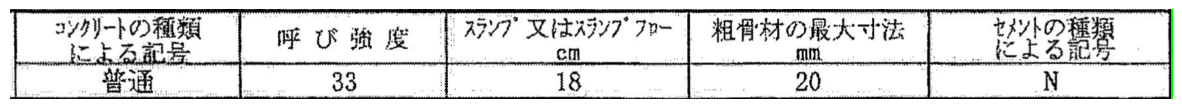

True

In [265]:
x_min_1 = min(rect[0] for rect in result_group_0)
y_min_1 = min(rect[1] for rect in result_group_0)

x_max_1 = max(rect[0] + rect[2] for rect in result_group_1)
y_max_1 = max(rect[1] + rect[3] for rect in result_group_1)

y_min_1 -= 10
y_max_1 += 0
x_min_1 -= 15
x_max_1 += 15
print(x_min_1, x_max_1, y_min_1, y_max_1)

image_result_1 = warped[y_min_1:y_max_1, x_min_1:x_max_1]

plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(image_result_1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

image_output_path = 'image_output_area1/image_output_area1_table_' + str(number_image) + '.jpg'
cv2.imwrite(image_output_path, image_result_1)

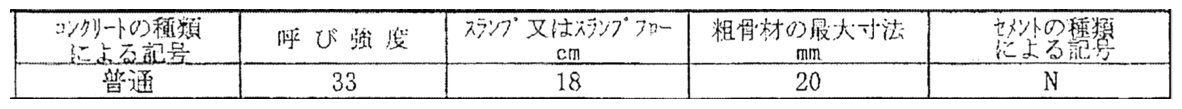

In [266]:
image_result_1_gray = cv2.cvtColor(image_result_1, cv2.COLOR_BGR2GRAY)
image_result_1 = cv2.GaussianBlur(image_result_1_gray, (5, 5), 0)
kernel_sharpening = np.array([[0, -1, 0],
                              [-1,  5.5, -1],
                              [0, -1, 0]])

# Áp dụng bộ lọc sắc nét
image_result_1 = cv2.filter2D(image_result_1, -1, kernel_sharpening)

plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(image_result_1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [267]:
from paddleocr import PaddleOCR

ocr = PaddleOCR(use_angle_cls=True, lang='japan')
ocr_en = PaddleOCR(use_angle_cls=True, lang='en')

result_text_area1 = []

if result_group_0:
    for i, (x, y, w, h) in enumerate(result_group_0, 1):
        image_crop = warped[y-5:y+h+5, x-5:x+w+5]
    
        # Đổi định dạng màu từ BGR sang RGB để phù hợp với PaddleOCR
        image_rgb = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
        
        # Nhận dạng văn bản từ hình ảnh cắt được
        result = ocr.ocr(image_rgb, cls=True)
        
        # Lưu kết quả nhận dạng vào file text
        result_text = ''
        for idx in range(len(result)):
            res = result[idx]
            if res:
                for line in res:
                    result_text += line[1][0] + '\n'
        print(f'Column {i}: \n {result_text}')

if result_group_1:
    for i, (x, y, w, h) in enumerate(result_group_1, 1):
        image_crop = warped[y-5:y+h+5, x-5:x+w+5]
    
        # Đổi định dạng màu từ BGR sang RGB để phù hợp với PaddleOCR
        image_rgb = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
        
        # Nhận dạng văn bản từ hình ảnh cắt được
        result = None
        if i == 1:
            result = ocr.ocr(image_rgb, cls=True)
        else:
            result = ocr_en.ocr(image_rgb, cls=True)
            
        # Lưu kết quả nhận dạng vào file text
        result_text = ''
        for idx in range(len(result)):
            res = result[idx]
            if res:
                for line in res:
                    result_text += line[1][0] + '\n'
        print(f'Column {i}: \n {result_text}')
        result_text_area1.append(result_text)

[2024/07/26 01:31:39] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\rec\\japan\\japan_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320'

## Lấy nội dung vùng yêu cầu thứ 2 ## 

In [213]:
result_text_area2_number = []
result_text_area2_percent = []

Second data area: x_min_2=0, y_min_2=0, x_max_2=15, y_max_2=5


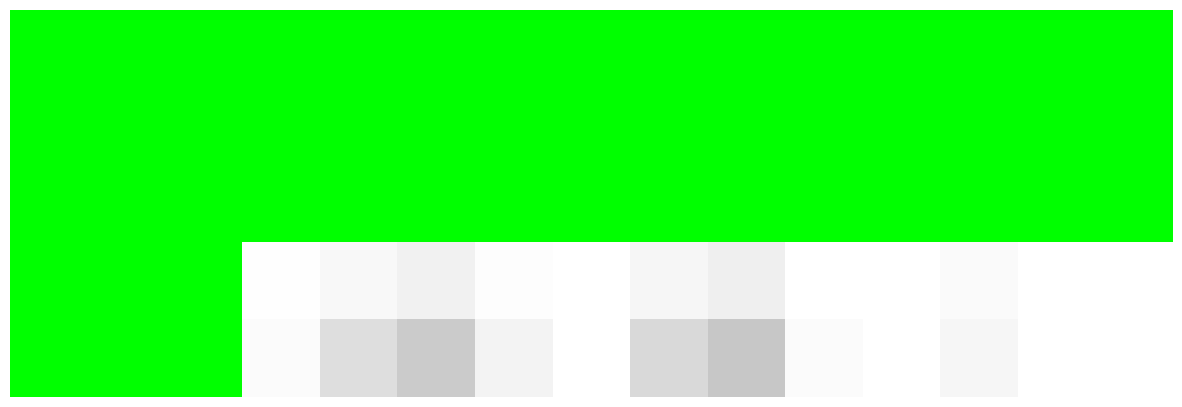

In [214]:
y_min_2 = max(0, y_min_2-5)
y_max_2 += 5
x_min_2 = max(0, x_min_2-5)
x_max_2 += 15
print(f"Second data area: x_min_2={x_min_2}, y_min_2={y_min_2}, x_max_2={x_max_2}, y_max_2={y_max_2}")

image_result_2 = warped[y_min_2:y_max_2, x_min_2:x_max_2]

plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(image_result_2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

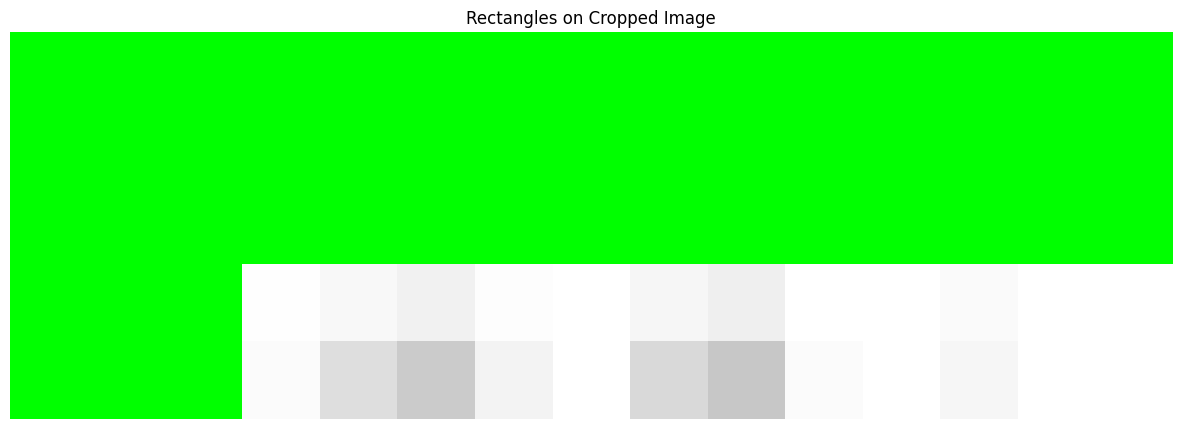

In [215]:
adjusted_rectangles = []
for rect in rectangles_sorted:
    x, y, w, h = rect
    if x_min_2 <= x <= x_max_2 and y_min_2 <= y <= y_max_2:
        adjusted_rect = (x - x_min_2, y - y_min_2, w, h)
        adjusted_rectangles.append(adjusted_rect)

# Vẽ các hình chữ nhật lên image_result_2
image_result_2_copy = image_result_2.copy()
for (x, y, w, h) in adjusted_rectangles:
    cv2.rectangle(image_result_2_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Màu xanh lá

# Hiển thị ảnh kết quả
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(image_result_2_copy, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Rectangles on Cropped Image')
plt.show()

Grouped Rectangles by Rows:
Row 1:
  Rectangle 1: x=0, y=0, width=1953, height=3017


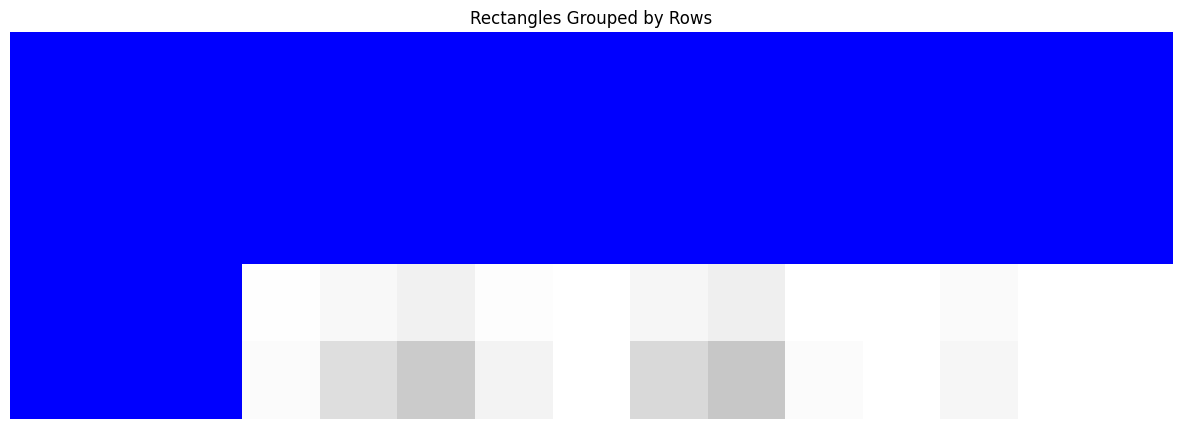

True

In [216]:
# Nhóm các hình chữ nhật theo hàng
def group_rectangles_by_rows(rectangles, row_threshold=10):
    rows = []
    rectangles_sorted_by_y = sorted(rectangles, key=lambda r: r[1])
    current_row = []

    for rect in rectangles_sorted_by_y:
        if not current_row:
            current_row.append(rect)
        else:
            _, y, _, _ = rect
            _, current_y, _, _ = current_row[-1]
            if abs(y - current_y) <= row_threshold:
                current_row.append(rect)
            else:
                rows.append(current_row)
                current_row = [rect]

    if current_row:
        rows.append(current_row)

    # Sắp xếp các hình chữ nhật trong mỗi hàng theo tọa độ x
    for row in rows:
        row.sort(key=lambda r: r[0])

    return rows

rows_of_rectangles = group_rectangles_by_rows(adjusted_rectangles)

# Hiển thị kết quả
print("Grouped Rectangles by Rows:")
for i, row in enumerate(rows_of_rectangles, 1):
    print(f"Row {i}:")
    for indx, rect in enumerate(row, 1):
        x, y, w, h = rect
        print(f"  Rectangle {indx}: x={x}, y={y}, width={w}, height={h}")

# Vẽ các hình chữ nhật theo hàng lên image_result_2
image_result_with_rows = image_result_2.copy()
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]  # Các màu khác nhau cho các hàng

for row_idx, row in enumerate(rows_of_rectangles):
    color = colors[row_idx % len(colors)]
    for (x, y, w, h) in row:
        cv2.rectangle(image_result_with_rows, (x, y), (x + w, y + h), color, 4)

# Hiển thị ảnh kết quả
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(image_result_with_rows, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Rectangles Grouped by Rows')
plt.show()

image_output_path = 'image_output_area2/image_output_area2_table_' + str(number_image) + '.jpg'
cv2.imwrite(image_output_path, image_result_with_rows)


In [217]:
def getTextOCR(rectangle_groups, language):
    result_texts = []

    ocr = PaddleOCR(use_angle_cls=True, lang=language)
    if rectangle_groups:
        for i, (x, y, w, h) in enumerate(rectangle_groups, 1):
            image_crop = image_result_2[y-4:y+h+4, x-4:x+w+4]
            
            # Đổi định dạng màu từ BGR sang RGB để phù hợp với PaddleOCR
            image_rgb = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
                
            # Nhận dạng văn bản từ hình ảnh cắt được
            result = ocr.ocr(image_rgb, cls=True)
                
            # Lưu kết quả nhận dạng vào file text
            result_text = ''
            for idx in range(len(result)):
                res = result[idx]
                if res:
                    for line in res:
                        result_text += line[1][0] + ' '
            result_texts.append(result_text)
    
    return result_texts

In [218]:
def count_sequences_with_same_start(array):
    result = []
    count = 1
    for i in range(1, len(array)):
        # So sánh 3 từ đầu của 2 chuỗi hiện tại và trước đó
        if array[i][:3] == array[i-1][:3]:
            count += 1
        else:
            result.append(count)
            count = 1
    
    # Ghi nhận số lượng từ liên tiếp cuối cùng
    result.append(count)
    
    return result

In [219]:
result_2_info_1_head = []
result_2_info_1 = []
result_2_info_2 = []

result_numbers = []
array_number_full = [1, 2, 1, 4, 4, 3]


if len(rows_of_rectangles) >= 4:
    if len(rows_of_rectangles[1]) > 6:
        result_2_info_1_head = rows_of_rectangles[1]
        result_2_info_1 = rows_of_rectangles[2]
        result_2_info_2 = rows_of_rectangles[3]

        # Xử lý dữ liệu lấy thông tin của 14 trường tham số: 1-2-1-4-3-3   <<== 1-2-1-3-3-3
        head_texts = getTextOCR(result_2_info_1_head, 'japan')
        value_texts = getTextOCR(result_2_info_1, 'en')
        array_number = count_sequences_with_same_start(head_texts)

        print(head_texts)
        print(value_texts)
        print(array_number)

        count = 0
        for indx, number in enumerate(array_number):
            for i in range(number):
                result_numbers.append(value_texts[count])
                count += 1
            if number < array_number_full[indx]:
                for i in range(array_number_full[indx] - number):
                    result_numbers.append('')
        
        print(result_numbers)
        

    else:
        if len(rows_of_rectangles[1]) == 6:
            result_2_info_1_head = rows_of_rectangles[1]
            result_2_info_1 = rows_of_rectangles[3]
            result_2_info_2 = rows_of_rectangles[4]

            value_texts = getTextOCR(result_2_info_1, 'en')


            array_number = []
            for (x, y, w, h) in result_2_info_1_head:
                count = 0
                for (x_sub, y_sub, w_sub, h_sub) in rows_of_rectangles[2]:
                    if x - 10 < x_sub and x_sub < x + w + 10:
                        count += 1
                    if x_sub > x + w:
                        break
                if count == 0:
                    count += 1
                array_number.append(count)

            count = 0
            for indx, number in enumerate(array_number):
                for i in range(number):
                    result_numbers.append(value_texts[count])
                    count += 1
                if number < array_number_full[indx]:
                    for i in range(array_number_full[indx] - number):
                        result_numbers.append('')
            
            print(result_numbers)
            
result_text_area2_number = result_numbers
print('--------')
print(result_numbers)
print(result_text_area2_number)
                

--------
[]
[]


In [220]:
print(array_number)

[1, 2, 1, 4, 3, 2]


In [221]:
print(getTextOCR(result_2_info_1_head, 'japan'))

[2024/07/26 01:17:59] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\rec\\japan\\japan_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320'

In [222]:
from paddleocr import PaddleOCR

ocr = PaddleOCR(use_angle_cls=True, lang='en')

result_number_percent = []

if result_2_info_2:
    for i, (x, y, w, h) in enumerate(result_2_info_2, 1):
        if i % 2 == 0:
            image_crop = image_result_2[y:y+h, x:x+w]
        
            # Đổi định dạng màu từ BGR sang RGB để phù hợp với PaddleOCR
            image_rgb = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
            
            # Nhận dạng văn bản từ hình ảnh cắt được
            result = ocr.ocr(image_rgb, cls=True)
            
            # Lưu kết quả nhận dạng vào file text
            result_text = ''
            for idx in range(len(result)):
                res = result[idx]
                if res:
                    for line in res:
                        result_text += line[1][0] + ' '
            print(f'Column {i}: \n {result_text}')

            result_text = result_text[:-2]

            if result_text:
                try:
                    number = float(result_text)
                    result_number_percent.append(number)
                except ValueError:
                    result_number_percent.append('')
            else:
                result_number_percent.append('')

print('-----------------------------------------------')
print(result_number_percent)

result_text_area2_percent = result_number_percent


[2024/07/26 01:18:00] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=

## Lấy nội dung vùng yêu cầu thứ 3 ## 

In [223]:
y_min_3 = None
y_max_3 = None
x_min_3 = None
x_max_3 = None
image_result_3 = None

result_text_area3 = []

In [224]:
if selected_rectangle_1 and selected_rectangle_2:

    x_min_3 = min(rect[0] for rect in info_row_group)
    y_min_3 = min(rect[1] for rect in info_row_group)

    x_max_3 = max(rect[0] + rect[2] for rect in info_row_group)
    y_max_3 = max(rect[1] + rect[3] for rect in info_row_group)

    y_min_3 -= 10
    y_max_3 += 0
    x_min_3 -= 15
    x_max_3 += 5
    print(x_min_3, x_max_3, y_min_3, y_max_3)

    image_result_3 = warped[y_min_3:y_max_3, x_min_3:x_max_3]

    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(image_result_3, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    image_output_path = 'image_output_area3/image_output_area3_table_' + str(number_image) + '.jpg'
    cv2.imwrite(image_output_path, image_result_3)

In [225]:
from paddleocr import PaddleOCR

ocr = PaddleOCR(use_angle_cls=True, lang='japan')

if info_row_group:
    for i, (x, y, w, h) in enumerate(info_row_group, 1):
        if i % 2 == 1: 
            image_crop = warped[y:y+h, x:x+w]
        
            # Đổi định dạng màu từ BGR sang RGB để phù hợp với PaddleOCR
            image_rgb = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
            
            # Nhận dạng văn bản từ hình ảnh cắt được
            result = ocr.ocr(image_rgb, cls=True)
            
            # Lưu kết quả nhận dạng vào file text
            result_text = ''
            for idx in range(len(result)):
                res = result[idx]
                if res:
                    for line in res:
                        result_text += line[1][0] + ' '
            print(f'Column {i}: \n {result_text}')
            result_text_area3.append(result_text)

[2024/07/26 01:18:02] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\rec\\japan\\japan_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320'

## Lấy nội dung vùng yêu cầu thứ 4 ## 

In [226]:
x_min_4 = None
y_min_4 = None
x_max_4 = None
y_max_4 = None
area_image_4 = None

result_text_area4 = []

In [227]:
if selected_rectangle_1:

    x, y, w, h = result_area_4
    x_min = max(0, x-10)
    y_min = max(0, y-8)
    x_max = min(image_width - 2, x+w+10)
    y_max = min(image_height - 2, y+h+8)
    area_image_4 = warped[y_min:y_max, x_min:x_max]

    plt.figure(figsize=(10, 10))
    plt.imshow(area_image_4)
    plt.axis('off')
    plt.show()

In [228]:
from paddleocr import PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='japan')

# Hàm tính tọa độ y trung bình của một box
def get_average_y(box):
    return (box[0][1] + box[1][1] + box[2][1] + box[3][1]) / 4

# Hàm tính tọa độ x trung bình của một box
def get_average_x(box):
    return (box[0][0] + box[1][0] + box[2][0] + box[3][0]) / 4

# Nhóm các box vào cùng một hàng và sắp xếp theo x
def group_boxes_by_line_and_sort_x(sorted_boxes, y_threshold=10):
    lines = []
    current_line = [sorted_boxes[0]]
    for i in range(1, len(sorted_boxes)):
        current_y = get_average_y(sorted_boxes[i][0])
        prev_y = get_average_y(current_line[-1][0])
        if abs(current_y - prev_y) < y_threshold:
            current_line.append(sorted_boxes[i])
        else:
            # Sắp xếp các box trong hàng theo x trung bình
            current_line_sorted = sorted(current_line, key=lambda x: get_average_x(x[0]))
            lines.append(current_line_sorted)
            current_line = [sorted_boxes[i]]
    if current_line:
        current_line_sorted = sorted(current_line, key=lambda x: get_average_x(x[0]))
        lines.append(current_line_sorted)
    return lines

[2024/07/26 01:18:03] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\rec\\japan\\japan_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320'

In [229]:
info_company = []

if selected_rectangle_1:
    result = ocr.ocr(area_image_4, cls=True)

    # Sắp xếp các box theo y trung bình
    result_sorted = []
    for res in result:
        res_sorted = sorted(res, key=lambda x: get_average_y(x[0]))
        result_sorted.append(res_sorted)


    # Gộp các box theo từng hàng, sắp xếp theo x và in kết quả
    for res_sorted in result_sorted:
        lines = group_boxes_by_line_and_sort_x(res_sorted)
        for line in lines:
            line_text = " ".join([word_info[1][0] for word_info in line])
            print(line_text)
            info_company.append(line_text)

    print(info_company)

result_text_area4 = info_company


In [230]:
# Vẽ hình chữ nhật bao quanh mỗi nhóm box
list_rectangle_area4 = []

if selected_rectangle_1:
    image_area_4_copy = area_image_4.copy()
    for res_sorted in result_sorted:
        lines = group_boxes_by_line_and_sort_x(res_sorted)
        for line in lines:
            # Tìm tọa độ x và y tối thiểu và tối đa
            min_x = min([min(box[0][0], box[1][0], box[2][0], box[3][0]) for box, _ in line])
            max_x = max([max(box[0][0], box[1][0], box[2][0], box[3][0]) for box, _ in line])
            min_y = min([min(box[0][1], box[1][1], box[2][1], box[3][1]) for box, _ in line])
            max_y = max([max(box[0][1], box[1][1], box[2][1], box[3][1]) for box, _ in line])
            # Lấy nội dung của text
            line_text = " ".join([word_info[1][0] for word_info in line])
            
            # Vẽ hình chữ nhật
            cv2.rectangle(image_area_4_copy, (int(min_x), int(min_y)), (int(max_x), int(max_y)), (0, 255, 0), 2)
            list_rectangle_area4.append(((int(min_x), int(min_y), int(max_x), int(max_y))))

    plt.figure(figsize=(10,10))
    plt.imshow(image_area_4_copy)
    plt.axis('off')
    plt.show()

    image_output_path = 'image_output_area4/image_output_area4_table_' + str(number_image) + '.jpg'
    cv2.imwrite(image_output_path, image_area_4_copy)

    for rectangle in list_rectangle_area4:
        print(rectangle)

In [231]:
company_name = None
company_address = None
people_name = None

In [232]:
search_terms = ["会社", "企業", "グループ", "有限", "株", "株式", "合同"]

for indx, text in enumerate(result_text_area4):
    if any(term in text for term in search_terms) and list_rectangle_area4[indx][0] > image_width * 0.3:
        company_name = text
        break

print(f"Company name: {company_name}")

people_names = list(filter(lambda x: "配合計画者名" in x, result_text_area4))
# Nếu có phần tử nào được tìm thấy, loại bỏ "配合計画者名" và lấy tên người
if people_names:
    people_name = people_names[0].replace("配合計画者名", "").strip()
print(f"People name: {people_name}")


Company name: None
People name: None


## Tính thời gian thực hiện ##

In [233]:
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Thời gian thực hiện: {elapsed_time} giây")

Thời gian thực hiện: 18.563714265823364 giây


In [234]:
result_content = f"""--------------------------------------------
Result of image {number_image}:
*** Area 1: {result_text_area1}
*** Area 2: {result_text_area2_number}
{result_text_area2_percent}
*** Area 3: {result_text_area3}
*** Area 4: {result_text_area4}
*** Company name: {company_name}
*** Address of company: {company_address}
*** People name: {people_name}
*** Time: {elapsed_time}
------------------------------------------------
"""

# Ghi nội dung vào file result.txt
with open("result.txt", "a", encoding="utf-8") as file:
    file.write(result_content)

print("Đã lưu kết quả vào file result.txt")

Đã lưu kết quả vào file result.txt
